In [317]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t, probplot
import matplotlib.pyplot as plt

## Portfolio

- SPY: €300 000
- AEX: €300 000
- RDSA: €10 000
- HSI: €90 000
- Bonds: €300 000

Total: €1 000 000

In [331]:
data = pd.read_csv('dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)

In [332]:
z = np.log(data[['SPY', 'AEX', 'RDSA.AS', 'HSI', 'USDEUR', 'HKDEUR']])
z['YIELDS'] = data['YIELDS'] / 100
x = z.diff()

c = np.zeros(x.shape)
c[:,-1] = z['YIELDS'] / 250 * 0.3

b = np.zeros(x.shape)
b[:,:] = [0.3, 0.3, 0.01, 0.09, 0.3, 0.09, 0.3]
b[:,-1] *= -np.arange(12, 0, -1/(250))[:len(x)]

l = -(c + b * x)

l

,SPY,AEX,RDSA.AS,HSI,USDEUR,HKDEUR,YIELDS
Date,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,-0.000000,-0.000000,-0.000000,-0.000000,0.000709,-0.000111,-0.000045
2010-01-05,-0.000793,0.000885,-0.000067,-0.001862,-0.001209,-0.000372,-0.000955
2010-01-06,-0.000211,0.000474,0.000072,-0.000552,0.000794,0.000211,0.000741
2010-01-07,-0.001264,0.000818,0.000030,0.000593,-0.001797,-0.000501,-0.001325
...,...,...,...,...,...,...,...
2020-04-20,0.001788,-0.001357,0.000027,0.000062,-0.000059,-0.000024,0.000005
2020-04-21,0.009250,0.010115,0.000488,0.002007,-0.000231,-0.000062,0.000001
2020-04-22,-0.006586,-0.008272,-0.000603,-0.000377,-0.001297,-0.000400,0.000009


## Assume normal distribution

In [351]:
mean = -c.mean() - b.mean(axis=0).dot(x.mean(axis=0)) * 1000000
std = np.sqrt(b.mean(0).dot(x.cov()).dot(b.mean(0))) * 1000000
# mean = l.mean().sum() * 1000000
# std = np.sqrt(l.cov().sum().sum()) * 1000000

In [352]:
"VaR 97.5%: €{0:.2f}".format(mean + std * norm.ppf(0.975))

'VaR 97.5%: €11620.87'

In [353]:
"VaR 99%: €{0:.2f}".format(mean + std * norm.ppf(0.99))

'VaR 99%: €13829.35'

In [354]:
"ES 97.5%: €{0:.2f}".format(mean + std * norm.pdf(norm.ppf(0.975)) / (1 - 0.975))

'ES 97.5%: €13898.40'

In [355]:
"ES 99%: €{0:.2f}".format(mean + std * norm.pdf(norm.ppf(0.99)) / (1 - 0.99))

'ES 99%: €15871.97'

## Assume students-t distribution

In [356]:
for v in [3, 4, 5, 6]:
    t_std = std / np.sqrt(v / (v - 2))
    print('---Degrees of freedom = {}---'.format(v))
    print("VaR 97.5%: €{0:.2f}".format(mean + std * t.ppf(0.975, v)))
    print("VaR 99%: €{0:.2f}".format(mean + std * t.ppf(0.99, v)))
    print("ES 97.5%: €{0:.2f}".format(mean + std * t.pdf(t.ppf(0.975, v), v) / (1 - 0.975) * (v + t.ppf(0.975, v)**2) / (v-1)))
          
    print("ES 99%: €{0:.2f}".format(mean + std * t.pdf(t.ppf(0.99, v), v) / (1 - 0.99) * (v + t.ppf(0.99, v)**2) / (v-1)))

---Degrees of freedom = 3---
VaR 97.5%: €18989.74
VaR 99%: €27177.03
ES 97.5%: €30184.18
ES 99%: €42019.74
---Degrees of freedom = 4---
VaR 97.5%: €16542.45
VaR 99%: €22392.43
ES 97.5%: €23878.95
ES 99%: €31275.21
---Degrees of freedom = 5---
VaR 97.5%: €15301.55
VaR 99%: €20089.71
ES 97.5%: €21033.95
ES 99%: €26644.93
---Degrees of freedom = 6---
VaR 97.5%: €14556.09
VaR 99%: €18749.97
ES 97.5%: €19434.02
ES 99%: €24113.85


## Test distribution assumptions

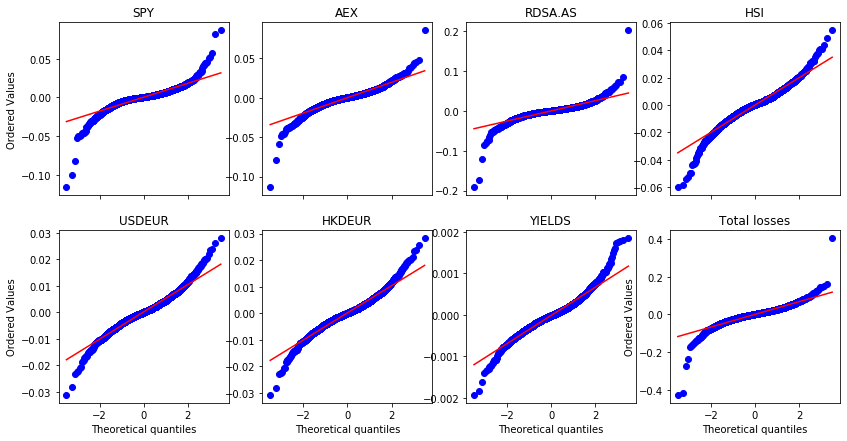

In [357]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=[14, 7], sharex=True)

for name, axis in zip(x.columns, [ax1, ax2, ax3, ax4, ax5, ax6, ax7]):
    probplot(x['{}'.format(name)][1:], dist="norm", plot=axis)
    axis.set_title('{}'.format(name))
    
probplot(x.sum(axis=1)[1:], dist="norm", plot=ax8)
ax8.set_title('Total losses')
    
[axis.set_xlabel('') for axis in [ax1, ax2, ax3, ax4]]
[axis.set_ylabel('') for axis in [ax2, ax3, ax4, ax6, ax7]]

plt.show()

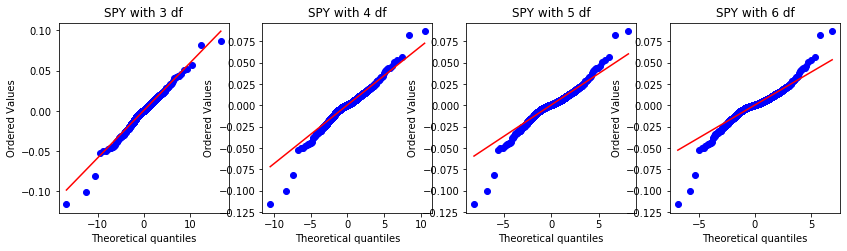

In [358]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=[14, 3.5])

for v, axis in zip([3, 4, 5, 6], ax):
    probplot(x['SPY'][1:], dist='t', sparams=(v), plot=axis)
    axis.set_title('SPY with {} df'.format(v))

plt.show()